In [1]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

19984


# 0. required packages for h5py

In [2]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [7]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH',
             'save_folder':r'G:\Pu_Temp\2020827_proB_DMSO',
             'experiment_type': 'DNA',
             'num_threads': 6,
             'correction_folder': r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20200807-Corrections_3color',
             'shared_parameters':{
                     'single_im_size':[30,2048,2048],
                     'corr_channels':['750', '647', '561'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':200,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,23)

In [8]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 200

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4, 
                                                                   _binary_per_th=99.5, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')

    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.5,
                                                             _cand_spot_intensity_th=intensity_th,
                                                             _save=True, 
                                                             _overwrite=overwrite)    
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 54
- Number of field of views: 71
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_30_2048

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3396.65s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_03.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_03.dax  in 15.264s
-- removing hot pixels for channels:['750'] in 5.210s
-- illumination correction for channels: 750, in 1.039s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 42.608s
-- finish correction in 119.600s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_03.hdf5
++ base 

E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 236 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 6 threads in 152.970s.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_03.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.030s.
+ loading unique from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_03.hdf5
++ finish loading unique in 0.048s. 
+ loading fov_info from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_03.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ base attributes loaded:[] in 0.477s.
- start select from 236 chromosomes with loss threshold=0.5
-- remove chr id 16, percentage of lost rounds:0.701.
-- remove chr id 116, percentage of lost rounds:0.632.
-- remove chr id 46, percentage of lost rounds:0.625.
-- remove chr id 126, percentage of lost rounds:0.618.
-- remove chr id 35, percentage of lost rounds:0.583.
-- remove chr id 55, percentage of lost rounds:0.583.
-- remove chr id 199, percentage of lost rounds:0.583.
-- remove chr id 54, percentage of lost rounds:0.569.
-- remove chr id 70, percentage of lost rounds:0.562.
-- remove chr id 78, percentage of lost rounds:0.562.
-- remove chr id 217, percentage of lost rounds:0.556.
-- remove chr id 141, percentage of lost rounds:0.528.
-- remove chr id 187, percentage of lost rounds:0.507.
-- remove chr id 190, percentage of lost rounds:0.507.
-- 222 chromosomes are kept.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_03.hdf5
++ base attributes saved:['chrom

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3277.98s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_04.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_04.dax  in 31.385s
-- removing hot pixels for channels:['750'] in 5.210s
-- illumination correction for channels: 750, in 1.020s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 42.465s
-- finish correction in 136.473s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_04.hdf5
++ base 

-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_05.dax
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_05.dax  in 15.796s
-- removing hot pixels for channels:['488'] in 5.269s
-- illumination correction for channels: 488, in 1.040s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.347s
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_05.hdf5
++ base attributes saved:['ref_im'] in 2.811s.
-- checking unique, region:[41 42 43] in 0.003s.
-- checking unique, region:[44 45 46] in 0.003s.
-- checking unique, region:[47 48 49] in 0.002s.
-- checkin

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_06.dax: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_06.hdf5.
* create savefile: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_06.hdf5
-- s

	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_06.dax  in 16.002s
-- removing hot pixels for channels:['750'] in 5.216s
-- illumination correction for channels: 750, in 1.032s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 42.520s
-- finish correction in 119.673s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_06.hdf5
++ base attributes saved:['chrom_im'] in 2.804s.
+ loading fov_info from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_06.hdf5
++ base attributes loaded:[] in 0.910s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 260 objects are found by segmentation.
- Start multiprocessing caluclat

-- checking unique, region:[87 88 89] in 0.002s.
-- checking unique, region:[90 91 92] in 0.002s.
-- checking unique, region:[93 94 95] in 0.003s.
-- checking unique, region:[96 97 98] in 0.002s.
-- checking unique, region:[ 99 100 101] in 0.002s.
-- checking unique, region:[102 103 104] in 0.002s.
-- checking unique, region:[105 106 107] in 0.002s.
-- checking unique, region:[108 109 110] in 0.002s.
-- checking unique, region:[111 112 113] in 0.002s.
-- checking unique, region:[114 115 325] in 0.003s.
-- checking unique, region:[323 321 328] in 0.004s.
-- checking unique, region:[326 324 331] in 0.002s.
-- checking unique, region:[329 327 334] in 0.002s.
-- checking unique, region:[332 330 341] in 0.002s.
-- checking unique, region:[335 333 344] in 0.002s.
-- checking unique, region:[339 337 347] in 0.002s.
-- checking unique, region:[342 340 350] in 0.002s.
-- checking unique, region:[345 343 353] in 0.002s.
-- checking unique, region:[348 346 356] in 0.002s.
-- checking unique, regi

-- saving 750_chromatic profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5.
-- saving 647_chromatic profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5.
-- saving 561_chromatic profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5.
-- 647_chromatic_constants profile already exist in save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5.
-- saving 750_647_561_bleed profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5.
-- saving unique to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 

-- remove chr id 219, percentage of lost rounds:0.549.
-- remove chr id 38, percentage of lost rounds:0.542.
-- remove chr id 94, percentage of lost rounds:0.542.
-- remove chr id 64, percentage of lost rounds:0.535.
-- remove chr id 190, percentage of lost rounds:0.528.
-- remove chr id 157, percentage of lost rounds:0.521.
-- remove chr id 214, percentage of lost rounds:0.521.
-- remove chr id 17, percentage of lost rounds:0.514.
-- 256 chromosomes are kept.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_08.hdf5
++ base attributes saved:['chrom_coords'] in 0.071s.
kept chromosomes: 256
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 54
- Number of field of views: 71
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3269.75s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_09.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_09.dax  in 25.875s
-- removing hot pixels for channels:['750'] in 5.251s
-- illumination correction for channels: 750, in 1.044s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 43.111s
-- finish correction in 130.471s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_09.hdf5
++ base 

-- finish correction in 21.796s
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_10.hdf5
++ base attributes saved:['ref_im'] in 2.776s.
-- checking unique, region:[41 42 43] in 0.003s.
-- checking unique, region:[44 45 46] in 0.002s.
-- checking unique, region:[47 48 49] in 0.002s.
-- checking unique, region:[50 51 52] in 0.002s.
-- checking unique, region:[53 54 55] in 0.003s.
-- checking unique, region:[56 57 59] in 0.002s.
-- checking unique, region:[60 61 62] in 0.003s.
-- checking unique, region:[63 64 65] in 0.002s.
-- checking unique, region:[66 67 68] in 0.002s.
-- checking unique, region:[69 70 71] in 0.002s.
-- checking unique, region:[72 73 74] in 0.002s.
-- checking unique, region:[75 76 77] in 0.002s.
-- checking unique, region:[78 79 80] in 0.002s.
-- checking unique, region:[81 82 83] in 0.002s.
-- checking unique, region:[84 85 86] in 0.002s.
-- checking unique, region:[87 88 89] in 0.002s.
-- checking unique, region:[90 91 92] in 0.002s.
-- checking 

-- saving 750_chromatic profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5.
-- saving 647_chromatic profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5.
-- saving 561_chromatic profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5.
-- 647_chromatic_constants profile already exist in save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5, skip.
-- saving 561_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5.
-- saving 750_647_561_bleed profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5.
-- saving unique to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 

-- remove chr id 208, percentage of lost rounds:0.569.
-- remove chr id 76, percentage of lost rounds:0.562.
-- remove chr id 94, percentage of lost rounds:0.562.
-- remove chr id 74, percentage of lost rounds:0.549.
-- remove chr id 92, percentage of lost rounds:0.535.
-- remove chr id 125, percentage of lost rounds:0.535.
-- remove chr id 231, percentage of lost rounds:0.535.
-- 263 chromosomes are kept.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_11.hdf5
++ base attributes saved:['chrom_coords'] in 0.072s.
kept chromosomes: 263
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 54
- Number of field of views: 71
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- l

+ Start multi-processing of pre-processing for 50 images with 6 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3245.81s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_12.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from fi

-- saving 750_647_561_bleed profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_13.hdf5.
-- saving unique to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_13.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.013s.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_13.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.016s.
-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_13.d

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_14.dax: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_14.hdf5.
* create savefile: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_14.hdf5
-- s

	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_14.dax  in 15.043s
-- removing hot pixels for channels:['750'] in 5.276s
-- illumination correction for channels: 750, in 1.032s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 43.282s
-- finish correction in 119.336s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_14.hdf5
++ base attributes saved:['chrom_im'] in 2.924s.
+ loading fov_info from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_14.hdf5
++ base attributes loaded:[] in 0.911s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 339 objects are found by segmentation.
- Start multiprocessing caluclat

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_15.dax  in 15.789s
-- removing hot pixels for channels:['488'] in 5.285s
-- illumination correction for channels: 488, in 1.024s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 22.334s
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_15.hdf5
++ base attributes saved:['ref_im'] in 2.790s.
-- checking unique, region:[41 42 43] in 0.003s.
-- checking unique, region:[44 45 46] in 0.002s.
-- checking unique, region:[47 48 49] in 0.002s.
-- checking unique, region:[50 51 52] in 0.002s.
-- checking unique, region:[53 54 55] in 0.002s.
-- checking unique, region:[56 57 59] in 0.003s.
-- checking unique, region:[60 61 62] in 0.002s.
-- checking unique, region:[63 64 65] in 0.002s.
-- checking unique, region:[66 67 68] in 0.002s.
-- checking unique, region:[69 70 71] in 0.003s.
-- checking unique, region:[72 73 74] in 0.002s.
-- chec

	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_16.dax: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5.
* create savefile: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.017s.
-- saving segmentation to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5


++ base attributes loaded:[] in 0.917s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 282 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 6 threads in 194.038s.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.024s.
+ loading unique from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5
++ finish loading unique in 0.053s. 
+ loading fov_info from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_16.hdf5
++ base attributes loaded:[] in 0.487s.
- start select from 282 chromosomes with loss threshold=0.5
-- remove chr id 60, percentage of lost rounds:0.785.
-- remove chr id 38, percentage of lost rounds:0.778.
-- remove chr id 37, percentage of lost rounds:0.757.
-- remove chr id 12, percentage

-- checking unique, region:[345 343 353] in 0.002s.
-- checking unique, region:[348 346 356] in 0.003s.
-- checking unique, region:[351 349 359] in 0.003s.
-- checking unique, region:[354 352 362] in 0.003s.
-- checking unique, region:[357 355 365] in 0.002s.
-- checking unique, region:[360 358 368] in 0.002s.
-- checking unique, region:[363 361 371] in 0.002s.
-- checking unique, region:[366 364 374] in 0.003s.
-- checking unique, region:[369 367 377] in 0.002s.
-- checking unique, region:[372 370 381] in 0.003s.
-- checking unique, region:[375 373 384] in 0.003s.
-- checking unique, region:[379 376 387] in 0.002s.
-- checking unique, region:[382 380 390] in 0.002s.
-- checking unique, region:[388 383 393] in 0.002s.
-- checking unique, region:[391 386] in 0.001s.
-- checking unique, region:[394 389] in 0.003s.
-- checking unique, region:[392] in 0.001s.
-- checking unique, region:[395] in 0.001s.
+ Start multi-processing of pre-processing for 50 images with 6 threads
++ processed uni

-- saving 750_647_561_bleed profile to save_file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_18.hdf5.
-- saving unique to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_18.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.003s.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_18.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'correction_folder', 'dapi_channel_index', 'data_folder', 'drift', 'drift_filename', 'drift_folder', 'experiment_folder', 'folders', 'fov_id', 'fov_name', 'map_folder', 'num_threads', 'ref_filename', 'ref_id', 'rotation', 'save_filename', 'save_folder', 'segmentation_dim', 'segmentation_folder', 'shared_parameters', 'use_dapi'] in 0.016s.
-- No folder selected, allow processing all 51 folders
+ load reference image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_18.d

-- remove chr id 18, percentage of lost rounds:0.521.
-- remove chr id 84, percentage of lost rounds:0.507.
-- remove chr id 131, percentage of lost rounds:0.507.
-- 269 chromosomes are kept.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_18.hdf5
++ base attributes saved:['chrom_coords'] in 0.072s.
kept chromosomes: 269
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 54
- Number of field of views: 71
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '561', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 51 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_561_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chrom

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3243.27s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_19.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_19.dax  in 15.560s
-- removing hot pixels for channels:['750'] in 5.266s
-- illumination correction for channels: 750, in 1.030s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 43.102s
-- finish correction in 120.113s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_19.hdf5
++ base 

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_20.dax  in 14.227s
-- removing hot pixels for channels:['488'] in 5.324s
-- illumination correction for channels: 488, in 1.044s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 20.837s
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_20.hdf5
++ base attributes saved:['ref_im'] in 2.793s.
-- checking unique, region:[41 42 43] in 0.100s.
-- checking unique, region:[44 45 46] in 0.003s.
-- checking unique, region:[47 48 49] in 0.002s.
-- checking unique, region:[50 51 52] in 0.002s.
-- checking unique, region:[53 54 55] in 0.002s.
-- checking unique, region:[56 57 59] in 0.002s.
-- checking unique, region:[60 61 62] in 0.002s.
-- checking unique, region:[63 64 65] in 0.002s.
-- checking unique, region:[66 67 68] in 0.003s.
-- checking unique, region:[69 70 71] in 0.002s.
-- checking unique, region:[72 73 74] in 0.003s.
-- chec

++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048_const.pkl
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048_const.pkl
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 561 illumination_correction_561_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_21.dax: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_21.hdf5.
* create savefile: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_21.hdf5
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_21.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_filename', 'color_format', 'cor

-- removing hot pixels for channels:['750'] in 5.267s
-- illumination correction for channels: 750, in 1.030s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 43.487s
-- finish correction in 120.418s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_21.hdf5
++ base attributes saved:['chrom_im'] in 2.862s.
+ loading fov_info from file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_21.hdf5
++ base attributes loaded:[] in 0.911s.
-- adjust seed image with filter size=4
-- binarize image with threshold: 99.5%
-- erosion and dialation with size=2.
-- find close objects.
-- random walk segmentation, beta=10.
-- find objects larger than size=50
-- 331 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 6 threads in 233.225s.
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_21.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.048

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3418.89s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_22.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_30_2048_2048.npy
	 647 None
	 561 chromatic_correction_561_647_30_2048_2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20200827-B_DMSO_CTP-08_IgH\H0R0\Conv_zscan_22.dax  in 15.331s
-- removing hot pixels for channels:['750'] in 5.256s
-- illumination correction for channels: 750, in 1.032s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 43.176s
-- finish correction in 119.897s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: G:\Pu_Temp\2020827_proB_DMSO\Conv_zscan_22.hdf5
++ base 

In [37]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
intensity_th = 500
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 29.959s
-- collapse all regions into 1d.


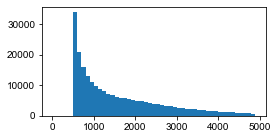

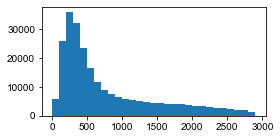

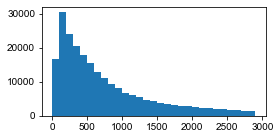

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 17.135s
-- region kept: 0.9655
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.245s
-- collapse all regions into 1d.


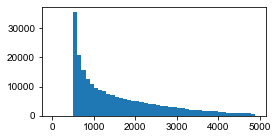

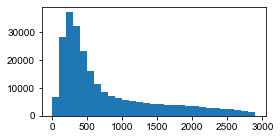

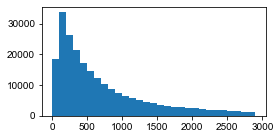

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.723s
-- region kept: 0.9933
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.255s
-- collapse all regions into 1d.


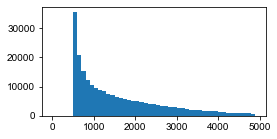

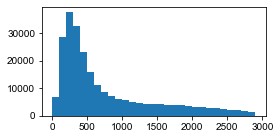

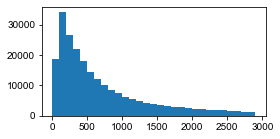

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 16.167s
-- region kept: 0.9932
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.105s
-- collapse all regions into 1d.


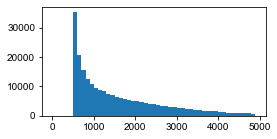

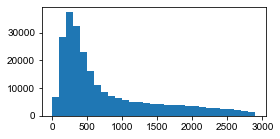

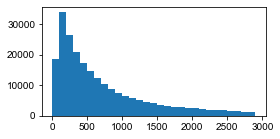

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.969s
-- region kept: 0.9932
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.041s
-- collapse all regions into 1d.


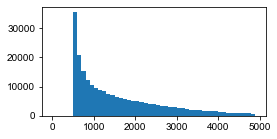

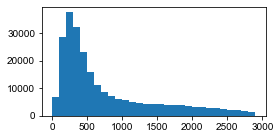

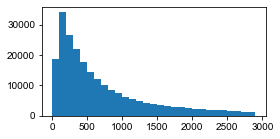

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.854s
-- region kept: 0.9933
- iter:5
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.241s
-- collapse all regions into 1d.


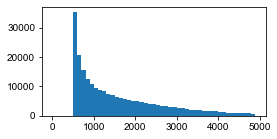

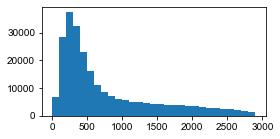

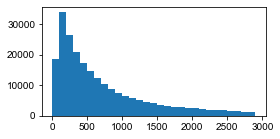

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.856s
-- region kept: 0.9932
- iter:6
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.190s
-- collapse all regions into 1d.


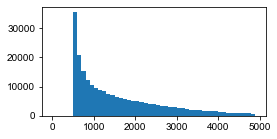

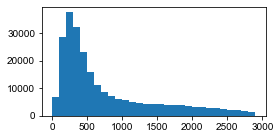

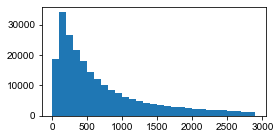

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 16.139s
-- region kept: 0.9932
- iter:7
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.057s
-- collapse all regions into 1d.


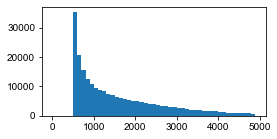

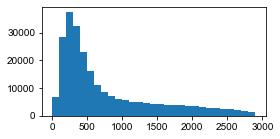

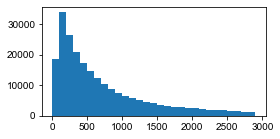

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 16.063s
-- region kept: 0.9932
- iter:8
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.218s
-- collapse all regions into 1d.


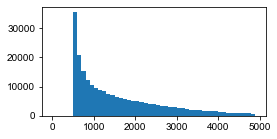

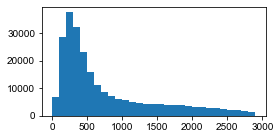

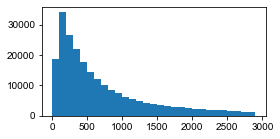

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 15.731s
-- region kept: 0.9933
- iter:9
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 27.182s
-- collapse all regions into 1d.


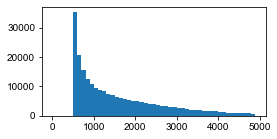

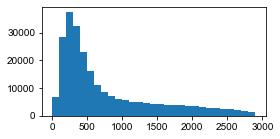

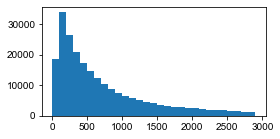

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 16.065s
-- region kept: 0.9932


In [38]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 12
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,5000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

In [39]:
np.ravel(sel_dna_scores_list[-1][:10000]).shape

(743904,)

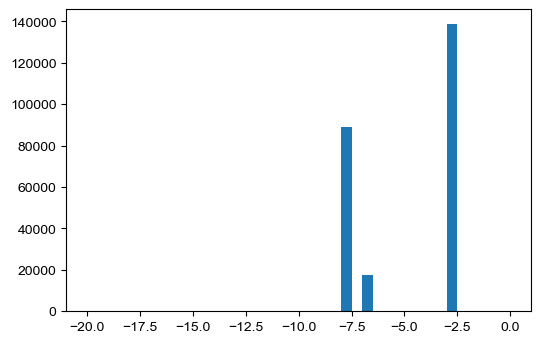

In [40]:
scores = np.array(sel_dna_scores_list[-1])[np.isnan(sel_dna_scores_list[-1])==False]
plt.figure(dpi=100)
plt.hist(np.log(scores), 40, range=(-20,0))
plt.show()

In [41]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
kept_chr_ids = []
distmap_list = []
score_th = np.exp(-10)
int_th = 500
bad_spot_percentage = 0.5

for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _bad_inds = _kept_hzxys[:,0] < int_th
    _kept_hzxys[_bad_inds] = np.nan
    #_kept_hzxys[_scores < score_th] = np.nan
    
    
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        kept_chr_ids.append(True)
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))
    else:
        kept_chr_ids.append(False)

kept_chr_ids = np.array(kept_chr_ids, dtype=np.bool)
distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


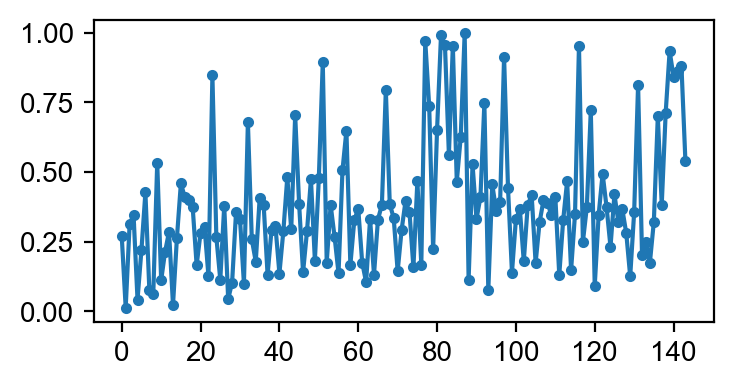

In [42]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [45]:
kept_inds = np.where(loss_rates<0.5)[0]

TypeError: plot_distance_map() got multiple values for argument 'ax'

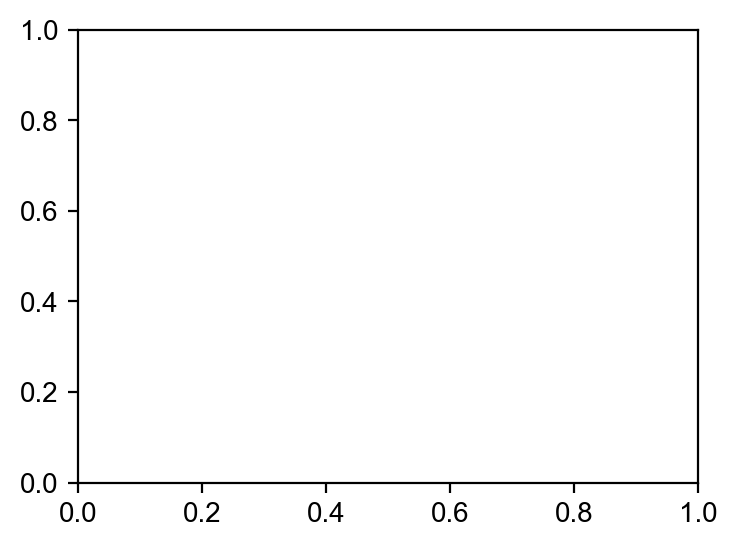

In [47]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.axvline(x=74, color=[1,1,0])
ax.axhline(y=74, color=[1,1,0])
ax.set_title(f"proB DMSO, n={len(distmap_list)}", fontsize=7.5)
plt.show()

###### 

In [ ]:
# generate full distmap
full_size = np.max(dna_reg_ids) - np.min(dna_reg_ids)+1

full_median_distmap = np.ones([full_size, full_size])*np.nan
full_median_distmap[np.arange(full_size), np.arange(full_size)] = np.zeros(len(full_median_distmap))
for _i, _id in enumerate(dna_reg_ids-np.min(dna_reg_ids)):
    full_median_distmap[_id, dna_reg_ids-np.min(dna_reg_ids)] = median_distmap[_i]
    

import matplotlib
median_cmap = matplotlib.cm.get_cmap('seismic_r')
median_cmap.set_bad(color=[0.4,0.4,0.4,1])

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(full_median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               cmap=median_cmap,
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0, np.max(dna_reg_ids)-np.min(dna_reg_ids), 50),
                                               tick_labels=np.arange(np.min(dna_reg_ids), np.max(dna_reg_ids),50), 
                                               figure_dpi=200)

ax.set_title(f"proB bone marrow IgH+/+, n={len(distmap_list)}", fontsize=7.5)
ax.set_xlabel(f"5kb region ids", fontsize=7.5)
plt.show()

# quality check

In [125]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['unique']
    _ind = list(_grp['ids'][:]).index(41)
    _im = _grp['ims'][_ind]
    sel_drifts = _grp['drifts'][:,:]
    sel_flags = _grp['flags'][:]
    sel_ids = _grp['ids'][:]
    sel_spots = _grp['spots'][:,:,:]
    print(_ind, np.sum(_grp['spots'][1]))

0 3826469.0


In [58]:
fov.unique_spots_list[100]

array([[ 6.56082726e+00,  2.59606991e+01,  6.11601379e+02, ...,
         7.73071229e-01, -3.07731796e-02,  1.70267914e+02],
       [ 4.22157383e+00,  2.32151070e+01,  9.43703918e+02, ...,
         4.81479615e-01,  6.38460398e-01,  1.23589035e+02],
       [ 3.96723986e+00,  2.77801933e+01,  7.93457642e+02, ...,
         7.53727496e-01,  9.04093564e-01,  1.02488930e+02],
       ...,
       [ 1.36868820e-01,  2.36938343e+01,  5.36140991e+02, ...,
         1.00000000e+00,  1.00000000e+00,  3.58169556e+01],
       [ 1.75873071e-01,  1.39472771e+01,  1.97251758e+03, ...,
        -2.08728582e-01, -6.80764616e-02,  3.75798035e+01],
       [ 1.79312319e-01,  2.28999996e+01,  8.71613098e+02, ...,
        -1.00000000e+00, -1.00000000e+00,  3.54034157e+01]], dtype=float32)

<IPython.core.display.Javascript object>


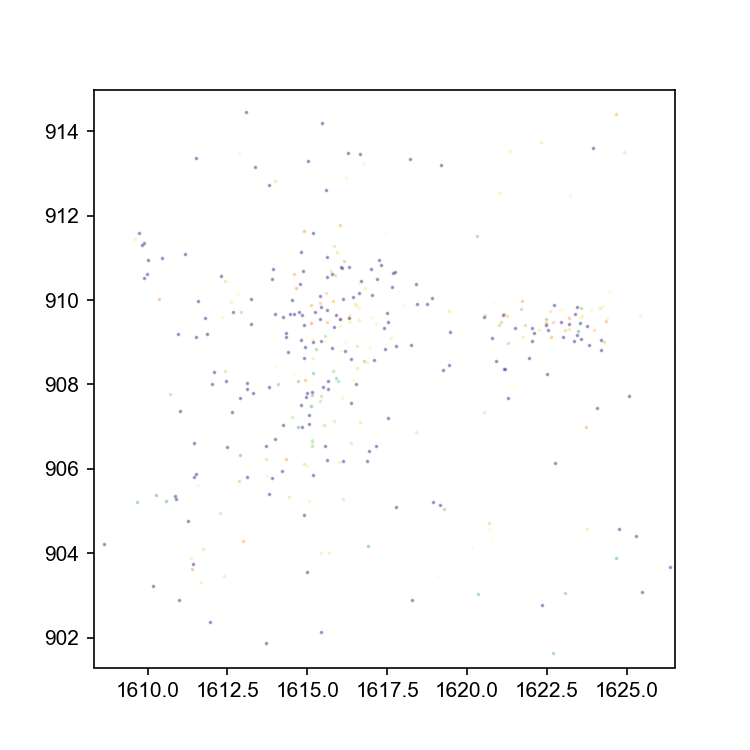

In [145]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)
for _id,_s in zip(sel_ids, kept_spots_list):
    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
plt.ylim([0,2048])
plt.xlim([0,2048])
#plt.legend()
plt.show()

array([[0.98592849, 0.63737024, 0.35963091, 1.        ],
       [0.98869666, 0.65736255, 0.36885813, 1.        ],
       [0.99146482, 0.67735486, 0.37808535, 1.        ],
       [0.99238754, 0.69388697, 0.39008074, 1.        ],
       [0.99269512, 0.70926567, 0.40299885, 1.        ],
       [0.9928489 , 0.71695502, 0.4094579 , 1.        ],
       [0.99315648, 0.73233372, 0.42237601, 1.        ],
       [0.99346405, 0.74771242, 0.43529412, 1.        ],
       [0.99377163, 0.76309112, 0.44821223, 1.        ],
       [0.99392541, 0.77078047, 0.45467128, 1.        ],
       [0.99423299, 0.78615917, 0.46758939, 1.        ],
       [0.99454056, 0.80153787, 0.4805075 , 1.        ],
       [0.99484814, 0.81691657, 0.49342561, 1.        ],
       [0.99515571, 0.83229527, 0.50634371, 1.        ],
       [0.9953095 , 0.83998462, 0.51280277, 1.        ],
       [0.99561707, 0.85536332, 0.52572088, 1.        ],
       [0.99592464, 0.87074202, 0.53863899, 1.        ],
       [0.99638601, 0.88796617,

## visualize pciked hzxys

<IPython.core.display.Javascript object>


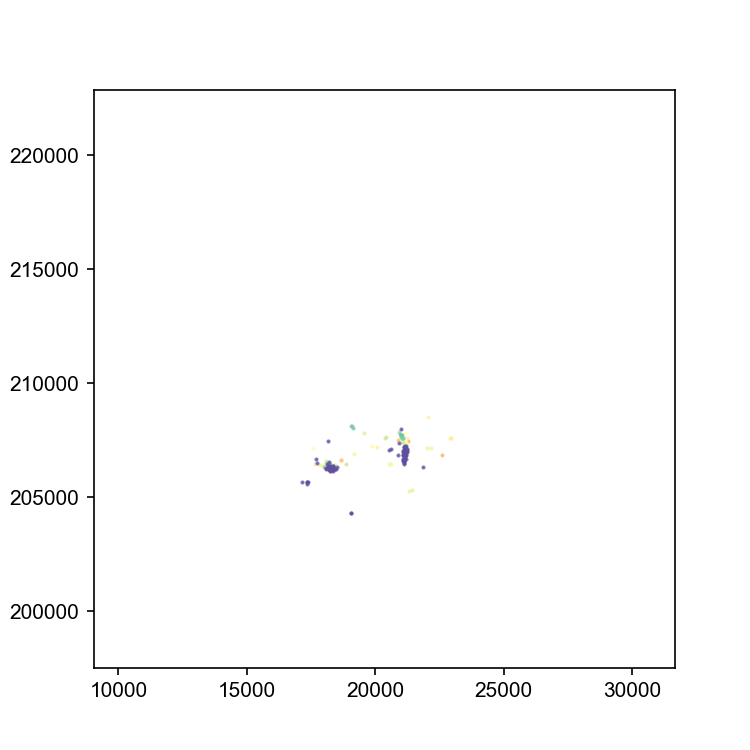

In [146]:
%matplotlib notebook
from matplotlib.cm import Spectral
plt.figure(figsize=(5,5),dpi=150)

for _i, _id in enumerate(sel_ids):
    plt.plot([_spots[_i,2] for _spots in final_dna_hzxys_list],
             [_spots[_i,3] for _spots in final_dna_hzxys_list],
             '.', markersize=2, color=Spectral(_id/(len(sel_ids)+1)), alpha=0.7)
#for _id,_s in zip(sel_ids, kept_spots_list):
#    plt.plot(_s[:,2],_s[:,3], '.', label=f'{_id}', 
#             markersize=1.5, color=Spectral(_id/len(sel_ids)), alpha=0.5)
#plt.legend()
#plt.ylim([0,2048])
#plt.xlim([0,2048])
#plt.legend()
plt.show()

## visualize fitted spots

<IPython.core.display.Javascript object>


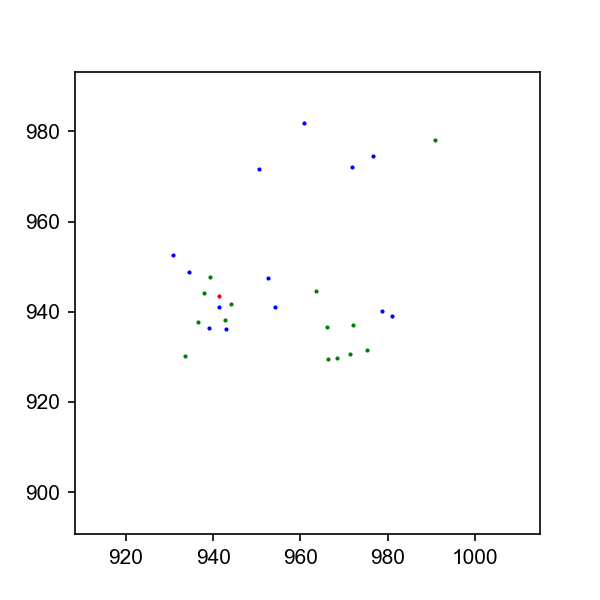

In [28]:
plt.figure(figsize=(4,4),dpi=150)
plt.plot(fov.chrom_coords[:,1], fov.chrom_coords[:,2], 'r.', markersize=2)
plt.plot(fov.unique_spots_list[0][:,2], fov.unique_spots_list[0][:,3], 'b.', markersize=2)
plt.plot(fov.unique_spots_list[-1][:,2], fov.unique_spots_list[-1][:,3], 'g.', markersize=2)

In [84]:
sel_drifts[kept_inds]

array([[ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.670e+00,  6.750e+00, -2.800e-01],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.660e+00,  3.018e+01,  0.000e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.580e+00,  3.860e+00,  2.620e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.570e+00, -4.690e+00,  2.610e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.540e+00,  5.300e-01,  2.060e+00],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.600e+00,  2.336e+01,  4.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.570e+00,  2.933e+01,  1.000e-02],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.560e+00,  2.841e+01, -1.500e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.510e+00,  2.522e+01, -1.100e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.280e+01, -2.500e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2.560e+00,  2.134e+01, -2.200e-01],
       [ 2

In [86]:
sel_drifts[kept_inds]

array([[  0.46, -16.34,  16.85],
       [  0.46, -16.34,  16.85],
       [  0.44,  -8.16,  14.05],
       [  0.44,  -8.16,  14.05],
       [  2.29,  -2.57,  15.59],
       [  2.29,  -2.57,  15.59],
       [  2.35,   8.53,  14.83],
       [  2.35,   8.53,  14.83],
       [  2.31,   6.76,  13.09],
       [  2.31,   6.76,  13.09],
       [  0.44, -15.23,  17.16],
       [  0.44, -15.23,  17.16],
       [  2.33, -16.8 ,  17.91],
       [  2.33, -16.8 ,  17.91],
       [  0.46, -16.95,  17.39],
       [  0.46, -16.95,  17.39],
       [  0.44, -18.39,  20.26],
       [  0.44, -18.39,  20.26],
       [  0.42, -18.18,  18.52],
       [  0.42, -18.18,  18.52],
       [  0.41, -18.32,  17.25],
       [  0.41, -18.32,  17.25],
       [  0.41, -17.91,  18.16],
       [  0.41, -17.91,  18.16],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.92,  17.75],
       [  0.41, -18.62,  16.99],
       [  0.41, -18.62,  16.99],
       [  0.42, -18.41,  17.88],
       [  0.42, -18.41,  17.88],
       [  

In [93]:
fov.fov_id

5

In [118]:
pickle.load(open(fov.drift_filename, 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '\\\\10.245.74.158\\Chromatin_NAS_6\\20201002-B_dox-IAA-STI+_CTP-08_IgH\\Analysis\\drift\\Conv_zscan_05_current_cor.pkl'

In [101]:
bead_im, _ = io_tools.load.correct_fov_image(os.path.join(fov.data_folder[0], 'H29R29\\Conv_zscan_05.dax'), 
                                             [fov.channels[fov.bead_channel_index]],
                                             correction_folder=fov.correction_folder,
                                             single_im_size=fov.shared_parameters['single_im_size'],
                                             all_channels=fov.channels,
                                             illumination_corr=True, 
                                             warp_image=False, calculate_drift=False, return_drift=False,
                                             verbose=True,
                                             )

- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H29R29\Conv_zscan_05.dax  in 8.028s
-- removing hot pixels for channels:['488'] in 7.301s
-- illumination correction for channels: 488, in 1.663s
-- generate translation function for chromatic correction for channels: [] and drift:[0. 0. 0.] in 0.001s
-- finish correction in 17.336s


In [109]:
correction_tools.alignment.cross_correlation_align_single_image(bead_im[0], fov.ref_im,
                                                                single_im_size=fov.shared_parameters['single_im_size'])

-- aligning image -> directly use image
-- directly use ref_image


array([-0.09, -9.87,  6.47])

<IPython.core.display.Javascript object>


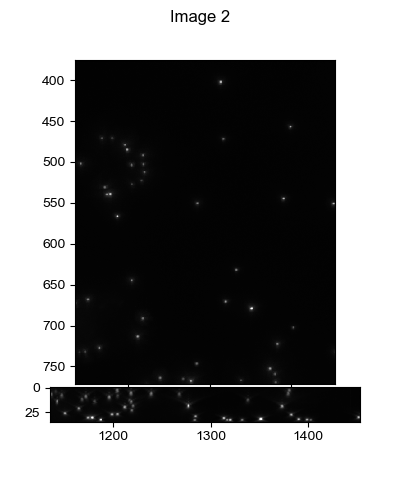

In [106]:
visual_tools.imshow_mark_3d_v2([bead_im[0], fov.ref_im])